# Retrieving the time lag between P-wave arrival and S-wave arrival in seismic recordings of tectonic tremor

## Looking at all the tremor from the same location

One problem with the pevious method is that the source of the tremor is moving with time. Now, if we look at all the one-minute-long time windows where the source of the tremor is located at about the same given location, the time lag between the P-wave and the S-wave should always be the same.

If we compute the cross correaltion of the vertical and the horizontal component, and then we stack over all the tremor windows, we should obtain a clear signal.

That what we are going to do now.

We begin by importing the Python modules that we will need during the analysis.

In [13]:
import obspy
import obspy.clients.earthworm.client as earthworm
import obspy.clients.fdsn.client as fdsn
from obspy import read_inventory
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.signal.cross_correlation import correlate

import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys

from scipy.io import loadmat
from math import pi, cos, sin, sqrt

from date import matlab2ymdhms
from stacking import linstack, powstack, PWstack

%matplotlib inline

We load the tremor catalog from A. Ghosh to know where and when we have tremor.

In [14]:
data = loadmat('../data/timelags/mbbp_cat_d_forHeidi')
mbbp_cat_d = data['mbbp_cat_d']
lat = mbbp_cat_d[:, 2]
lon = mbbp_cat_d[:, 3]

As in the previous example, we look at the data from the Big Skidder array.

In [15]:
network = 'XU'
arrayName = 'BS'
staNames = ['BS01', 'BS02', 'BS03', 'BS04', 'BS05', 'BS06', 'BS11', 'BS20', 'BS21', 'BS22', 'BS23', 'BS24', 'BS25', \
    'BS26', 'BS27']
chaNames = ['SHE', 'SHN', 'SHZ']
staCodes = 'BS01,BS02,BS03,BS04,BS05,BS06,BS11,BS20,BS21,BS22,BS23,BS24,BS25,BS26,BS27'
chans = 'SHE,SHN,SHZ'

We also need to know the location of the array.

In [16]:
# Location of the center of the array
lat0 = 47.95728
lon0 = -122.92866

We choose to look at all the tremor located in a 5 km by 5 km square cell, centered around the array.

In [17]:
# Size and location of cell
ds = 5.0
x0 = 0.0
y0 = 0.0
# Formula to convert degrees in latitude and longitude into kilometers
a = 6378.136
e = 0.006694470
dx = (pi / 180.0) * a * cos(lat0 * pi / 180.0) / sqrt(1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0))
dy = (3.6 * pi / 648.0) * a * (1.0 - e * e) / ((1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0)) ** 1.5)
# Latitude and longitude of the edges of the square cell
lonmin = lon0 + (x0 - 0.5 * ds) / dx
lonmax = lon0 + (x0 + 0.5 * ds) / dx 
latmin = lat0 + (y0 - 0.5 * ds) / dy
latmax = lat0 + (y0 + 0.5 * ds) / dy

We now look at the time when we have tremor in this square cell.

In [18]:
find = np.where((lat >= latmin) & (lat <= latmax) & (lon >= lonmin) & (lon <= lonmax))
tremor = mbbp_cat_d[find, :][0, :, :]
nt = np.shape(tremor)[0]
print(nt)

70


Tremor with a source located in this square cell were recorded during 70 minutes. That should be enough to have a good signal on the stack of the cross correlations. We are now going to choose one of the tremor window, and look at what the cross correlation look like.

In [19]:
i = 0

We need to convert the beginning and end time of the time window we are interested in from the Matlab format to the Python format.

In [20]:
(YY1, MM1, DD1, HH1, mm1, ss1) = matlab2ymdhms(tremor[i, 0])
t1 = UTCDateTime(str(YY1) + '-' + str(MM1) + '-' + str(DD1) + 'T' + str(HH1) + ':' + str(mm1) + ':' + str(ss1))
(YY2, MM2, DD2, HH2, mm2, ss2) = matlab2ymdhms(tremor[i, 1])
t2 = UTCDateTime(str(YY2) + '-' + str(MM2) + '-' + str(DD2) + 'T' + str(HH2) + ':' + str(mm2) + ':' + str(ss2))

We are going to download 10 additional seconds of data before and after, in order to taper the signal.

In [21]:
Tstart = t1 - 10.0
Tend = t2 + 10.0

As in the previous example, we dowload the data, remove the stations with missing data, detrend, taper 5 seconds at the beginning end at the end of the time window, remove the instrument response, filter, and resample.

In [22]:
fdsn_client = fdsn.Client('IRIS')

# or you can try:
# earthworm_client = earthworm.Client('rainier.ess.washington.edu', 16017)

Dtmp = fdsn_client.get_waveforms(network=network, station=staCodes, location='--', channel=chans, starttime=Tstart, \
    endtime=Tend, attach_response=True)

# or you can try:
# Dtmp = Stream()
# for ksta in range(0, len(staNames)):
#     for kchan in range(0, len(chaNames)):
#         trace = earthworm_client.get_waveforms( network=network, station=staNames[ksta], location='', \
#             channel=chaNames[kchan], starttime=Tstart, endtime=Tend)
#             if len(trace) > 0:
#                 Dtmp.append(trace[0])

ntmp = []
for ksta in range(0, len(Dtmp)):
    ntmp.append(len(Dtmp[ksta]))
ntmp = max(set(ntmp), key=ntmp.count)
D = Dtmp.select(npts=ntmp)
D.detrend(type='linear')
D.taper(type='hann', max_percentage=None, max_length=5.0)
D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

# or you can try:
# filename = '../data/response/' + network + '_' + arrayName + '.xml'
# inventory = read_inventory(filename, format='STATIONXML')
# D.attach_response(inventory)
# D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)
            
D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
D.interpolate(100.0, method='lanczos', a=10)
D.decimate(5, no_filter=True)      

/anaconda3/envs/seismic/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


15 Trace(s) in Stream:
XU.BS01..SHE | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS01..SHN | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS01..SHZ | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS02..SHE | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS02..SHN | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS02..SHZ | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS03..SHE | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS03..SHN | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS03..SHZ | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS04..SHE | 2009-07-18T05:41:50.000000Z - 2009-07-18T05:43:10.000000Z | 20.0 Hz, 1601 samples
XU.BS04

We select only the one-minute-long time window for which we have tremor.

In [23]:
EW = D.select(component='E').slice(t1, t2)
UD = D.select(component='Z').slice(t1, t2)

We compute the cross correlation for each seismic station as in the previous example.

In [24]:
ncor = 400
cc = Stream()
for ksta in range(0, len(EW)):
    cc.append(EW[ksta].copy())
    cc[-1].data = correlate(EW[ksta], UD[ksta], ncor)
    cc[-1].stats['channel'] = 'CC'

And we stack the cross correlations over all the stations.

In [25]:
stack = linstack([cc], normalize=False)

# or you can do:
# stack = powstack([cc], 2.0, normalize=False)
# stack = PWstack([cc], 2.0, normalize=False)

We can now look at the cross correlation signal:

In [26]:
def plot_cc(cc, amp, ncor, Tmax, stack, title):
    """ Plot cross correlation
        cc = Stream
        amp = Amplification factor
        ncor = Maximum number of samples for cross correlation
        Tmax = Maximum time lag to be plotted
        stack = Stream
        title = Title of the figure       
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    t = (1.0 / cc[0].stats.sampling_rate) * np.arange(- ncor, ncor + 1)
    for ksta in range(0, len(cc)):
        plt.plot(t, 2 * ksta + 1 + amp * cc[ksta].data, 'k')
    plt.plot(t, -1.0 + amp * 5.0 * stack[0].data, 'r')
    plt.xlim(0.0, Tmax)
    plt.ylim(-2.0, 2.0 * len(cc))
    plt.title(title, fontsize=24)
    plt.xlabel('Time lag (s)', fontsize=24)
    ax.set_yticklabels([])
    ax.tick_params(labelsize=20)

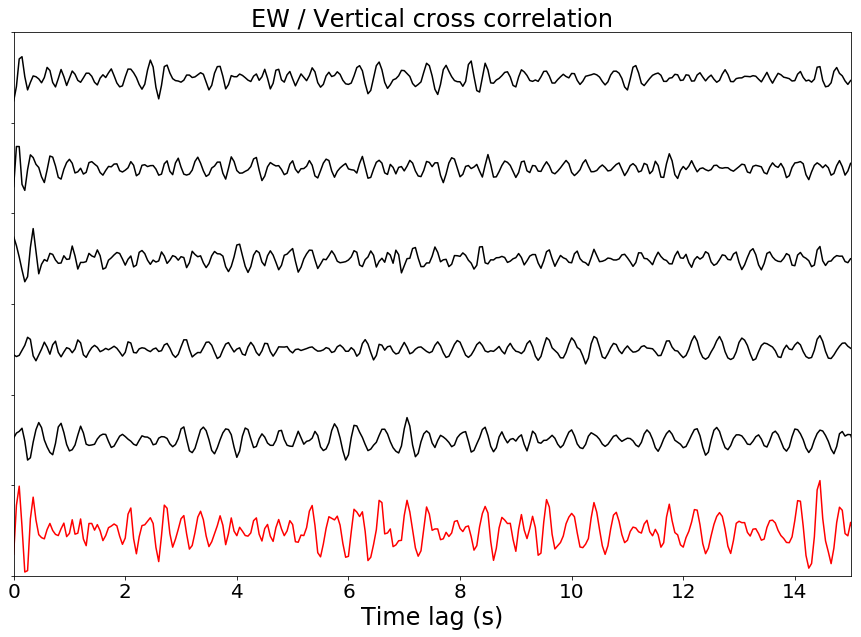

In [27]:
plot_cc(cc, 3.0, 400, 15.0, stack, 'EW / Vertical cross correlation')

We can compute the stack of the cross correlation for all the tremor windows, and store it in a file.

In [ ]:
EW = Stream()
for i in range(0, nt):
    (YY1, MM1, DD1, HH1, mm1, ss1) = matlab2ymdhms(tremor[i, 0])
    t1 = UTCDateTime(str(YY1) + '-' + str(MM1) + '-' + str(DD1) + 'T' + str(HH1) + ':' + str(mm1) + ':' + str(ss1))
    Tstart = t1 - 10.0
    (YY2, MM2, DD2, HH2, mm2, ss2) = matlab2ymdhms(tremor[i, 1])
    t2 = UTCDateTime(str(YY2) + '-' + str(MM2) + '-' + str(DD2) + 'T' + str(HH2) + ':' + str(mm2) + ':' + str(ss2))
    Tend = t2 + 10.0
    try:
        Dtmp = fdsn_client.get_waveforms(network=network, station=staCodes, location='--', channel=chans, \
            starttime=Tstart, endtime=Tend, attach_response=True)

#         Dtmp = Stream()
#         for ksta in range(0, len(staNames)):
#             for kchan in range(0, len(chaNames)):
#                 trace = earthworm_client.get_waveforms(network=network, station=staNames[ksta], location='', \
#                     channel=chaNames[kchan], starttime=Tstart, endtime=Tend)
#                 if len(trace) > 0:
#                     Dtmp.append(trace[0])

    except:
        message = 'Cannot open waveform file for tremor {} ({:04d}/{:02d}/{:02d} at {:02d}:{:02d}:{:02d})'. \
            format(i + 1, YY1, MM1, DD1, HH1, mm1, ss1)
        print(message)
    else:
        ntmp = []
        for ksta in range(0, len(Dtmp)):
            ntmp.append(len(Dtmp[ksta]))
        ntmp = max(set(ntmp), key=ntmp.count)
        D = Dtmp.select(npts=ntmp)
        D.detrend(type='linear')
        D.taper(type='hann', max_percentage=None, max_length=5.0)
        D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

#         filename = '../data/response/' + network + '_' + arrayName + '.xml'
#         inventory = read_inventory(filename, format='STATIONXML')
#         D.attach_response(inventory)
#         D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

        D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
        D.interpolate(100.0, method='lanczos', a=10)
        D.decimate(5, no_filter=True)         
        EW = D.select(component='E').slice(t1, t2)
        UD = D.select(component='Z').slice(t1, t2)
        t = (1.0 / EW[0].stats.sampling_rate) * np.arange(- ncor, ncor + 1)
        cc = Stream()
        for ksta in range(0, len(staNames)):
            cc.append(EW.select(station=staNames[ksta])[0].copy())
            cc[-1].data = correlate( \
                        EW.select(station=staNames[ksta])[0], \
                        UD.select(station=staNames[ksta])[0], ncor)
                    cc[-1].stats['channel'] = 'CC'
                    cc[-1].stats['station'] = staNames[ksta]
                    if (draw_plot == True):
                        plt.plot(t, (2.0 * ksta + 1) + amp * cc[-1].data, 'k-')
            # Stack cross correlations within the array and plot
            if (type_stack == 'lin'):
                stack = linstack([cc], normalize=False)[0]
            elif (type_stack == 'pow'):
                stack = powstack([cc], w, normalize=False)[0]
            elif (type_stack == 'PWS'):
                stack = PWstack([cc], w, normalize=False)[0]
            else:
                raise ValueError( \
                    'Type of stack must be lin, pow, or PWS')
            EW.append(stack)
            if (draw_plot == True):
                plt.plot(t, - 2.0 + amp_stack * stack.data, 'r-')
                plt.xlim(0, Tmax)
                plt.ylim(- 4.0, 2.0 * len(staNames) + 1.0)
                plt.title('East / Vertical component', loc='right', \
                    fontsize=24)
                plt.xlabel('Lag time (s)', fontsize=24)
                plt.ylabel('Cross correlation', fontsize=24)
                ax.set_yticklabels([])
                ax.tick_params(labelsize=20)
            # NS - UD cross correlation
            if (draw_plot == True):
                ax = plt.subplot(212)
            cc = Stream()
            for ksta in range(0, len(staNames)):
                if (D.select(station=staNames[ksta], channel=chaNames[0]) and \
                    D.select(station=staNames[ksta], channel=chaNames[1]) and \
                    D.select(station=staNames[ksta], channel=chaNames[2])):
                    cc.append(NS.select(station=staNames[ksta])[0].copy())
                    cc[-1].data = correlate( \
                        NS.select(station=staNames[ksta])[0], \
                        UD.select(station=staNames[ksta])[0], ncor)
                    cc[-1].stats['channel'] = 'CC'
                    cc[-1].stats['station'] = staNames[ksta]
                    if (draw_plot == True):
                        plt.plot(t, (2.0 * ksta + 1) + amp * cc[-1].data, 'k-')
            # Stack cross correlations within the array and plot
            if (type_stack == 'lin'):
                stack = linstack([cc], normalize=False)[0]
            elif (type_stack == 'pow'):
                stack = powstack([cc], w, normalize=False)[0]
            elif (type_stack == 'PWS'):
                stack = PWstack([cc], w, normalize=False)[0]
            else:
                raise ValueError( \
                    'Type of stack must be lin, pow, or PWS')
            NS.append(stack)
            if (draw_plot == True):
                plt.plot(t, - 2.0 + amp_stack * stack.data, 'r-')
                plt.xlim(0, Tmax)
                plt.ylim(- 4.0, 2.0 * len(staNames) + 1.0)
                plt.title('North / Vertical component', loc='right', \
                    fontsize=24)
                plt.xlabel('Lag time (s)', fontsize=24)
                plt.ylabel('Cross correlation', fontsize=24)
                ax.set_yticklabels([])
                ax.tick_params(labelsize=20)
                title = '{} on {:04d}/{:02d}/{:02d} at {:02d}:{:02d}:{:02d}'. \
                    format(arrayName, YY1, MM1, DD1, HH1, mm1, ss1)
                plt.suptitle(title, fontsize=24)
                filename = 'cc/{}_{:04d}{:02d}{:02d}_{:02d}{:02d}{:02d}.eps'. \
                    format(arrayName, YY1, MM1, DD1, HH1, mm1, ss1)
                plt.savefig(filename, format='eps')
                ax.clear()
                plt.close(1)

    # Save stacked cross correlations into file
    if nt > 0:
        filename = 'cc/{}_{:03d}_{:03d}_{}.pkl'.format(arrayName, int(x0), \
            int(y0), type_stack)
        pickle.dump([t, EW, NS], open(filename, 'wb'))
